# DSND Project 1 - Notebook

### Import Libraries and Data

In [103]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

# Sklearn utilities
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimalpoints

In [104]:
listings = pd.read_csv('listings.csv')

### Data Cleaning

In [105]:
listings_start = listings.copy()

In [106]:
columns_to_start = ['host_is_superhost','host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 
                    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
                    'beds', 'bed_type', 'price', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                    'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 
                    'calculated_host_listings_count', 'reviews_per_month']

# Immediately trim down to only columns that seem most useful
listings_start = listings_start[columns_to_start]

In [107]:
# Make price numerical
listings_start['price'] = listings_start['price'].map(lambda x: str(x)[1:])
listings_start['price'].replace(regex=True,inplace=True,to_replace=r',',value=r'')
listings_start.price = pd.to_numeric(listings_start.price)

In [108]:
# Make object variables categorical
cols = ['host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 
        'instant_bookable', 'cancellation_policy']
for col in cols:
    listings_start[col] = listings_start[col].astype('category')

In [109]:
# Drop all rows without ratings (which are listings never used and not useful data points)
listings_start = listings_start.dropna()

In [110]:
# Rename neighbourhood
listings_start.rename(columns={"neighbourhood_cleansed":"neighbourhood"}, inplace=True)

In [111]:
# Make variable int
listings_start.bedrooms = listings_start.bedrooms.astype(int)

In [112]:
columns_price_ratings = ['price','number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'review_scores_accuracy', 
 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
 'review_scores_value']

# Make dataframe with price and ratings
listings_price_ratings = listings_start[columns_price_ratings]

# Make dataframe with only ratings
listings_ratings = listings_price_ratings.drop(['price'], axis =1)

### Data Exploration and Visualization

In [113]:
# Look at correlation matrix for price with numerical values
listing_cor = listings_start.corr()[['price']]
best_predictors = list(listing_cor.sort_values(['price'], ascending = False).index)
corrmat = listings_start[best_predictors].corr()
corrmat

,price,accommodates,bedrooms,beds,bathrooms,guests_included,host_listings_count,host_total_listings_count,calculated_host_listings_count,review_scores_location,review_scores_cleanliness,review_scores_rating,review_scores_accuracy,review_scores_value,review_scores_communication,review_scores_checkin,minimum_nights,number_of_reviews,reviews_per_month
price,1.000,0.593,0.546,0.518,0.336,0.310,0.237,0.237,0.222,0.193,0.143,0.106,0.040,0.012,0.005,-0.006,-0.022,-0.109,-0.159
accommodates,0.593,1.000,0.738,0.829,0.331,0.520,0.126,0.126,0.121,0.008,0.089,0.035,0.012,-0.010,-0.010,-0.015,-0.052,-0.007,0.004
bedrooms,0.546,0.738,1.000,0.710,0.425,0.424,0.124,0.124,0.081,-0.048,0.074,0.054,0.023,0.023,0.015,0.010,-0.019,-0.045,-0.064
beds,0.518,0.829,0.710,1.000,0.344,0.491,0.051,0.051,0.036,-0.014,0.063,0.033,0.008,-0.003,0.006,-0.002,-0.029,-0.019,-0.006
bathrooms,0.336,0.331,0.425,0.344,1.000,0.121,0.133,0.133,0.133,-0.028,0.026,0.002,-0.019,-0.014,-0.047,-0.053,0.009,-0.024,-0.051
guests_included,0.310,0.520,0.424,0.491,0.121,1.000,-0.089,-0.089,-0.093,0.009,0.048,0.047,0.056,0.015,0.068,0.016,-0.024,0.043,0.043
host_listings_count,0.237,0.126,0.124,0.051,0.133,-0.089,1.000,1.000,0.959,0.013,-0.025,-0.128,-0.180,-0.203,-0.243,-0.222,0.036,-0.131,-0.192
host_total_listings_count,0.237,0.126,0.124,0.051,0.133,-0.089,1.000,1.000,0.959,0.013,-0.025,-0.128,-0.180,-0.203,-0.243,-0.222,0.036,-0.131,-0.192
calculated_host_listings_count,0.222,0.121,0.081,0.036,0.133,-0.093,0.959,0.959,1.000,0.003,-0.028,-0.145,-0.194,-0.223,-0.265,-0.232,0.047,-0.133,-0.199
review_scores_location,0.193,0.008,-0.048,-0.014,-0.028,0.009,0.013,0.013,0.003,1.000,0.346,0.455,0.320,0.437,0.282,0.275,-0.030,-0.041,0.010


#### Question 1: How much can I make?

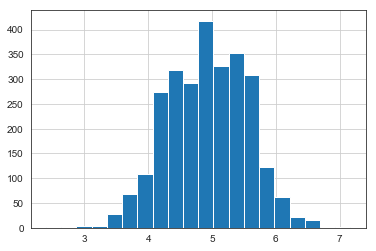

In [114]:
# Price is lognormal
np.log(listings_start.price).hist(bins=20)

In [115]:
# Statistics by room_type
room_type = listings_start.groupby('room_type').price.describe().iloc[:,[0,1,3,7]]
room_type

,count,mean,min,max
room_type,,,,
Entire home/apt,1622.000,220.403,11.000,1300.000
Private room,1059.000,89.163,20.000,499.000
Shared room,53.000,78.019,22.000,500.000


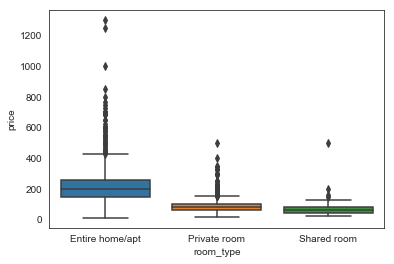

In [116]:
sns.boxplot(y = 'price', x = 'room_type', data = listings_start)

In [117]:
# Statistics by bedrooms
bedrooms = listings_start.groupby('bedrooms').price.describe().iloc[:,[0,1,3,7]]
bedrooms

,count,mean,min,max
bedrooms,,,,
0,233.000,149.790,55.000,269.000
1,1817.000,126.906,11.000,699.000
2,506.000,253.957,65.000,700.000
3,126.000,315.603,84.000,1250.000
4,40.000,411.100,150.000,750.000
5,12.000,487.583,225.000,1300.000


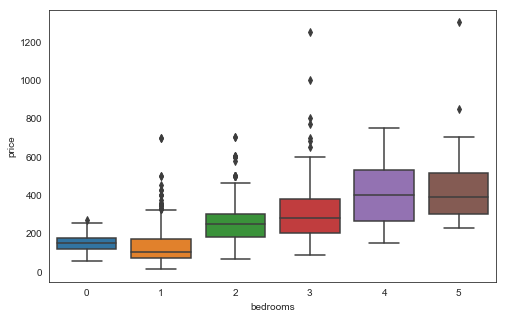

In [118]:
fig, ax = plt.subplots(figsize=(8,5)) 
sns.boxplot(y = 'price', x = 'bedrooms', data = listings_start, ax=ax)

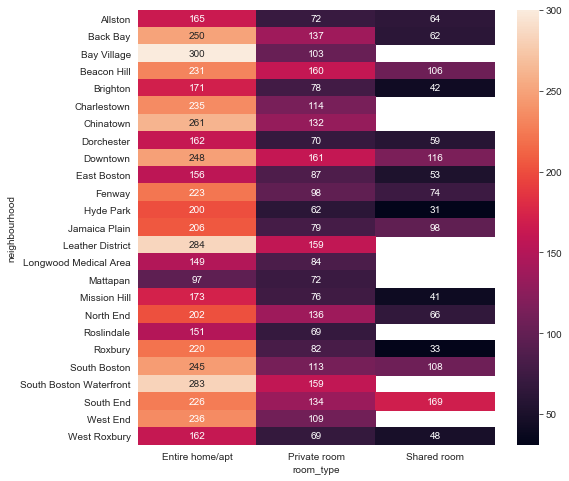

In [119]:
# mean price by neighborhood and room type
fig, ax = plt.subplots(figsize=(8,8))       
sns.heatmap(listings_start.groupby(['neighbourhood', 'room_type']).price.mean().unstack(),annot=True, fmt=".0f", ax=ax)

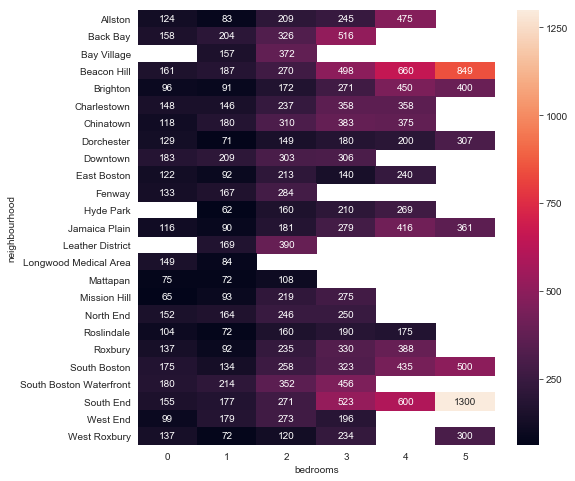

In [120]:
# Mean price by neighborhood and bedrooms
fig, ax = plt.subplots(figsize=(8,8))  
sns.heatmap(listings_start.groupby(['neighbourhood', 'bedrooms']).price.mean().unstack(),annot=True, fmt=".0f", ax=ax)

#### Question 2: Now that I know the range of prices. What's in my control?

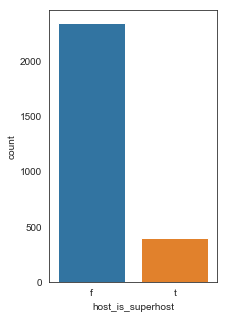

In [121]:
# Most hosts arent doing a great job. You can maximize profits by being a superhost and booking more nights.
# Not al ot of people are superhosts
fig, ax = plt.subplots(figsize=(3,5))  
sns.countplot(x="host_is_superhost", data=listings_start, ax=ax)

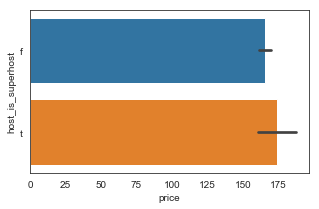

In [122]:
# But the mean income for superhosts is higher
fig, ax = plt.subplots(figsize=(5,3))  
sns.barplot(x='price', y='host_is_superhost', data=listings_start)

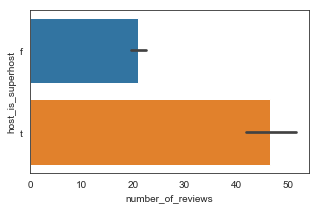

In [123]:
# And they get more reviews
fig, ax = plt.subplots(figsize=(5,3))  
sns.barplot(x='number_of_reviews', y='host_is_superhost', data=listings_start)

#### Question 3: What about the relationship of price and ratings?

In [124]:
# Cleanliness appears to be important for obtaining a higher price. Location isn't in your control and nothing else really matters.
listing_cor = listings_price_ratings.corr()[['price']]
best_predictors = list(listing_cor.sort_values(['price'], ascending = False).index)

reviews_corr = listings_start[best_predictors].corr().iloc[0,1:]
r_corr1 = pd.DataFrame(reviews_corr)
r_corr1

,price
review_scores_location,0.193
review_scores_cleanliness,0.143
review_scores_rating,0.106
review_scores_accuracy,0.040
review_scores_value,0.012
review_scores_communication,0.005
review_scores_checkin,-0.006
number_of_reviews,-0.109
reviews_per_month,-0.159


In [125]:
# Look at how review components are intercorrelated
listing_cor = listings_ratings.corr()[['review_scores_rating']]
best_predictors = list(listing_cor.sort_values(['review_scores_rating'], ascending = False).index)

ratings_corr = listings_start[best_predictors].corr().iloc[0,1:]
r_corr2 = pd.DataFrame(ratings_corr)
r_corr2

,review_scores_rating
review_scores_value,0.786
review_scores_cleanliness,0.754
review_scores_accuracy,0.702
review_scores_communication,0.602
review_scores_checkin,0.582
review_scores_location,0.455
reviews_per_month,0.081
number_of_reviews,0.024


### Modelling

Modelling was done for understanding but the graphs and results weren't used in the blog post.

In [126]:
# Drop 4 outliers to improve modelling
listings_model = listings_start.drop(listings_start[listings_start.price > 800].index)

In [127]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# Improves modelling but not great for interpretation
listings_model.price = np.log1p(listings_model.price)

In [128]:
# Standardize numerical columns
scaler = StandardScaler()
num_cols = listings_model.select_dtypes(include=['int','float']).columns

listings_model[num_cols] = scaler.fit_transform(listings_model[num_cols])

In [129]:
# one-hot encode
listings_onehot = pd.get_dummies(listings_model)
print(listings_onehot.shape)

(2730, 73)


Ridge: 0.587420 (0.060413)
RF: 0.592206 (0.078901)
GBM: 0.626353 (0.077608)
XGBoost: 0.625297 (0.073979)


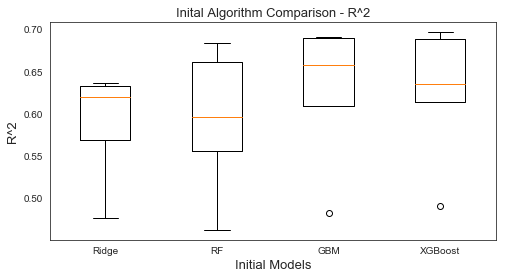

In [130]:
X = listings_onehot.drop(['price'], axis = 1)
Y = listings_onehot['price']

# Comparing several starter models with r^2
models = []
models.append(('Ridge', Ridge()))
models.append(('RF', RandomForestRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('XGBoost', XGBRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Compare Algorithms
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Inital Algorithm Comparison - R^2', fontsize=13)
plt.ylabel('R^2', fontsize=13)
plt.xlabel('Initial Models', fontsize=13)
plt.show()

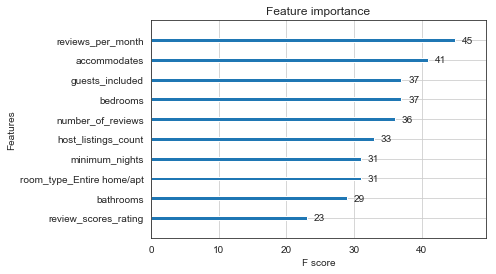

In [131]:
# Plot feature importance
model = XGBRegressor()
model.fit(X, Y)

plot_importance(model, max_num_features = 10)
plt.show()

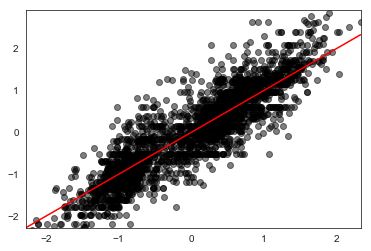

In [132]:
# Scatter Plot of predicted vs actual house prices
preds = model.predict(X)
x = preds
y = Y
lineStart = preds.min() 
lineEnd = preds.max()  

plt.figure()
plt.scatter(x, y, color = 'k', alpha=0.5)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd*1.25)
plt.show()